# Système de recommendation : premiers pas NLTK 

Ce notebook a pour but de présenter les premières observations que l'on obtient en regardant les commentaires des utilisateurs laissés aux jeux dans la base de donnée avis_clean.csv. Il se découpe en deux parties : le nettoyage (récupération des BDD pertinentes) et exposition des histogrammes.

In [1]:
# Importations pertinentes : filtering_text, bdd avis (à filtrer)
import pandas as pd
import numpy as np
from reco_systems.filter import filter_df
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.util import ngrams

from spellchecker import SpellChecker
import seaborn as sns

FR_stopwords = stopwords.words("french")

### Setup for Frenc! lemmatisation

In [3]:
# import os 
# jar = '/Users/bsh2022/Study/L3/Projet_recherche/stanford-postagger-full-2020-11-17/stanford-postagger.jar'
# model = '/Users/bsh2022/Study/L3/Projet_recherche/stanford-postagger-full-2020-11-17/models/french-ud.tagger'

# os.environ['JAVAHOME'] = '/Library/Java/JavaVirtualMachines/jdk-20.jdk/Contents/Home' 

In [2]:
from unidecode import unidecode # remove french accents

In [16]:
# for word in FR_stopwords:
#     if "que" in word:
#         print(word)
#FR_stopwords += ['donc', 'alors', 'que', 'qui', 'car', 'parce']

In [3]:
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", names=["Username", "User id"])

min_reviews = 10
rev_filter = filter_df(avis_clean, min_reviews)

df = rev_filter[['Game id', 'User id', 'Rating', 'Comment title', 'Comment body']].copy()

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [10]:
# .apply(unidecode) in the end if necessary (delete french accents)
text = rev_filter[["Comment title", "Comment body"]].apply(lambda x : " ".join(x.values.astype(str)), axis=1).str.lower().apply(unidecode)
text.head(10)

0     voyages sur les ailes des papillons lorsque le...
1     le festival de michoacan comment continuer apr...
2     vivez la migration des monarques vin d'jeu: av...
3     manque un peu de souffle mariposas est plutot ...
4     beau et doux et rapide mariposas est un jeu ou...
6     peut-etre pas uniquement familial il est tres ...
7     mysterium sans ses defauts vin d'jeu: ce << no...
8     chapeau l'artiste en famille nous avons bien p...
9     parc a theme j'ai eu l'occasion de jouer a des...
11    mysterium light fan de la serie mysterium c'es...
dtype: object

### Remove punctuation

In [12]:
#punc_to_delete = string.punctuation.replace("\'", "") # ' can have meaning?
punc_to_delete = string.punctuation
punc_to_delete

trans_table = str.maketrans(punc_to_delete, " " * len(punc_to_delete))
text = text.str.translate(trans_table)

### Remove French stopwords

In [18]:
text = text.apply(lambda x : " ".join([word for word in x.split() if word not in FR_stopwords]))

### Tokenization

In [19]:
text_df = text.to_frame().rename(columns={0 : "Text"})
text_df["Tokens"] = text.apply(lambda row: nltk.word_tokenize(row))
# text_df

In [20]:
tokens = text_df[["Tokens"]]
tokens

,Tokens
0,"[voyages, ailes, papillons, lorsque, jeu, jeu,..."
1,"[festival, michoacan, comment, continuer, apre..."
2,"[vivez, migration, monarques, vin, jeu, maripo..."
3,"[manque, peu, souffle, mariposas, plutot, beau..."
4,"[beau, doux, rapide, mariposas, jeu, tension, ..."
...,...
142459,"[piou, boum, badaboum, crac, re, piou, petit, ..."
142460,"[star, wars, revisite, jeu, vaisseau, spaciaux..."
142461,"[piou, piou, mag, blast, jeu, rapide, drole, s..."
142462,"[peewww, peeeww, mort, pu, jouer, a, 2, moyen,..."


In [21]:
words = tokens.explode("Tokens")
words["Len"] = words["Tokens"].str.len()
words = words[words["Len"] > 1]
words

,Tokens,Len
0,voyages,7
0,ailes,5
0,papillons,9
0,lorsque,7
0,jeu,3
...,...,...
142465,tres,4
142465,attrayant,9
142465,voir,4
142465,partie,6


### Replace repeating caracters

In [22]:
words["Tokens"] = words["Tokens"].str.replace(r"(.)\1+", r"\1", regex=True)
words[words["Len"] >= 35]

,Tokens,Len
3873,projetgarfieldsoutenuplusoumoinsvraimentpariel...,64
3873,sortirmaisbononeveutpasvexergarfieldalorsonyva...,83
4309,0498c8d916ad49814197846cadefc70a89f,36
6869,enquetescoperatifimersifmaterielbeaute,40
8755,wargh,45
...,...,...
131964,whoanon,35
137964,4f7f9c9170798ac31d37f461d7c76512a7,36
137964,4f7f9c9170798ac31d37f461d7c76512a7ps5,39
138712,cartesrejouabilitefraicheurprixpoints,37


### Remove hex-like words

In [23]:
# at least one digit and hex like structure
words = words[~words["Tokens"].str.match(r"^(?=.*\d)[a-z0-9]{20,}$", na=False)]

### Replace digits with ''

In [24]:
words["Tokens"] = words["Tokens"].str.replace(r'\d+', '', regex=True)

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_28281/2062898132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Tokens"] = words["Tokens"].str.replace(r'\d+', '', regex=True)


In [25]:
words[words["Tokens"].str.match(r"\d+")]

,Tokens,Len


In [26]:
# Recalc length 
words["Len"] = words["Tokens"].str.len()
words

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_28281/217479811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Len"] = words["Tokens"].str.len()


,Tokens,Len
0,voyages,7
0,ailes,5
0,papilons,8
0,lorsque,7
0,jeu,3
...,...,...
142465,tres,4
142465,atrayant,8
142465,voir,4
142465,partie,6


In [27]:
# limit words length
words = words[(words["Len"] > 1) & (words["Len"] < 25)]
words["Tokens"].value_counts()

Tokens
jeu              224273
plus              90753
tres              71701
bien              66651
tout              57262
                  ...  
denrier               1
laboraqualite         1
expliquerla           1
sympautre             1
chouraver             1
Name: count, Length: 96669, dtype: int64

### Part of speech tags (for lemmatization) -> long. Stemming for now

In [ ]:
# pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')
# lim_tokens = tokens[:100]
# lim_tokens["Tokens"].apply(lambda row : pos_tagger.tag(row))

0      [(voyages, NOUN), (ailes, NOUN), (papillons, N...
1      [(festival, NOUN), (michoacan, ADJ), (comment,...
2      [(vivez, VERB), (migration, NOUN), (monarques,...
3      [(manque, VERB), (peu, ADV), (souffle, VERB), ...
4      [(beau, ADJ), (doux, ADJ), (rapide, ADJ), (mar...
                             ...                        
175    [(puntogo, INTJ), (jeu, NOUN), (emporter, VERB...
187    [(bon, ADJ), (domaine, NOUN), (grand, ADJ), (f...
188    [(jubilatoire, ADJ), (addictif, NOUN), (poule,...
189    [(excellent, ADJ), (petit, ADJ), (jeu, NOUN), ...
190    [(sympa, ADJ), (sens, NOUN), (assez, ADV), (pr...
Name: Tokens, Length: 100, dtype: object

In [28]:
stemmer = FrenchStemmer()
words["Stems"] = words["Tokens"].apply(stemmer.stem)
words = words[~words["Stems"].isna()]
words

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_28281/1798391041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Stems"] = words["Tokens"].apply(stemmer.stem)


,Tokens,Len,Stems
0,voyages,7,voyag
0,ailes,5,ail
0,papilons,8,papilon
0,lorsque,7,lorsqu
0,jeu,3,jeu
...,...,...,...
142465,tres,4,tre
142465,atrayant,8,atrai
142465,voir,4,voir
142465,partie,6,part


In [29]:
words["Len_stems"] = words["Stems"].str.len()

### Analyze stems length

In [30]:
words["Len_stems"].value_counts()

Len_stems
4     1815690
3     1227255
5     1044261
6      826686
7      638548
8      312546
2      163737
9      132646
10      44005
11      28367
12       9930
13       4044
1        1904
14       1146
15        894
17        372
16        357
18        149
19         77
20         46
21         25
22         21
23         19
24         10
Name: count, dtype: int64

### Limit stems lengths to 14 max

In [31]:
words["Len_stems"].value_counts()

Len_stems
4     1815690
3     1227255
5     1044261
6      826686
7      638548
8      312546
2      163737
9      132646
10      44005
11      28367
12       9930
13       4044
1        1904
14       1146
15        894
17        372
16        357
18        149
19         77
20         46
21         25
22         21
23         19
24         10
Name: count, dtype: int64

In [33]:
words_filter = words[(words["Len_stems"] > 1) & (words["Len_stems"] <= 15)]

In [34]:
words_filter["Stems"].value_counts()

Stems
jeu           224285
plus           90757
part           79373
tre            71736
tout           70783
               ...  
antihorair         1
playbok            1
andean             1
ruhnk              1
miral              1
Name: count, Length: 58701, dtype: int64

In [35]:
words_imploded = words_filter.groupby(words_filter.index)['Stems'].apply(list).reset_index(drop=True).to_frame().rename(columns={0 : "Stems"})
words_imploded

,Stems
0,"[voyag, ail, papilon, lorsqu, jeu, jeu, bon, r..."
1,"[festival, michoacan, coment, continu, apre, m..."
2,"[viv, migrat, monarqu, vin, jeu, maripos, eliz..."
3,"[manqu, peu, soufl, maripos, plutot, beau, gra..."
4,"[beau, doux, rapid, maripos, jeu, tension, va,..."
...,...
96528,"[piou, boum, badaboum, crac, re, piou, pet, je..."
96529,"[star, war, revisit, jeu, vaiseau, spacial, as..."
96530,"[piou, piou, mag, blast, jeu, rapid, drol, san..."
96531,"[pew, pew, mort, pu, jou, moyen, pu, fouil, bi..."


In [36]:
words_imploded["Comment stemmed"] = words_imploded["Stems"].apply(lambda row : " ".join(row))
words_imploded

,Stems,Comment stemmed
0,"[voyag, ail, papilon, lorsqu, jeu, jeu, bon, r...",voyag ail papilon lorsqu jeu jeu bon reflex jo...
1,"[festival, michoacan, coment, continu, apre, m...",festival michoacan coment continu apre meg hit...
2,"[viv, migrat, monarqu, vin, jeu, maripos, eliz...",viv migrat monarqu vin jeu maripos elizabeth h...
3,"[manqu, peu, soufl, maripos, plutot, beau, gra...",manqu peu soufl maripos plutot beau grand plat...
4,"[beau, doux, rapid, maripos, jeu, tension, va,...",beau doux rapid maripos jeu tension va exacerb...
...,...,...
96528,"[piou, boum, badaboum, crac, re, piou, pet, je...",piou boum badaboum crac re piou pet jeu bien f...
96529,"[star, war, revisit, jeu, vaiseau, spacial, as...",star war revisit jeu vaiseau spacial asez symp...
96530,"[piou, piou, mag, blast, jeu, rapid, drol, san...",piou piou mag blast jeu rapid drol san pretent...
96531,"[pew, pew, mort, pu, jou, moyen, pu, fouil, bi...",pew pew mort pu jou moyen pu fouil bien tout s...


In [39]:
words_imploded[["Comment stemmed"]].to_csv("generated_data/comments_stemmed.csv")

In [173]:
freq = words_filter["Stems"].value_counts().to_frame().reset_index()

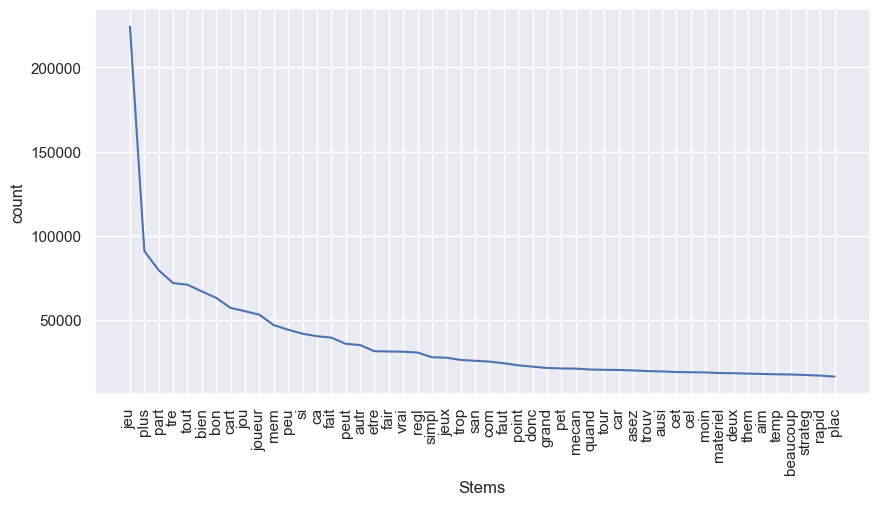

In [174]:
sns.set_theme(rc={'figure.figsize' : (10, 5)})
lim_freq = freq[:50]
ax = sns.lineplot(data=lim_freq, x="Stems", y="count")
ax.tick_params(axis='x', rotation=90)

In [ ]:
# import re

# hex_like_pattern = r'(?=.*\d)\b[a-z0-9]{32,40}\b' #.str.replace
# #repeat_chars_pattern = r"(.)\1+", r"\1" 

# repeat_chars_pattern = r'([a-zA-Z])\1+'

# # Function to reduce repeated characters to a single occurrence
# def reduce_repeated_characters(text):
#     return re.sub(repeat_chars_pattern, r'\1', text)

# def replace_hashes(text):
#     # Replace with a placeholder like '<HASH>'
#     return re.sub(hex_like_pattern, '', text)

# text_df = text.to_frame().rename(columns={0 : "Text"})
# #text_df = text_df[["Text"]]
# text_df

,Text
0,voyages ailes papillons lorsque jeu jeu bon re...
1,festival michoacan comment continuer apres meg...
2,vivez migration monarques vin jeu mariposas el...
3,manque peu souffle mariposas plutot beau grand...
4,beau doux rapide mariposas jeu tension va exac...
...,...
142459,piou boum badaboum crac re piou petit jeu bien...
142460,star wars revisite jeu vaisseau spaciaux assez...
142461,piou piou mag blast jeu rapide drole sans pret...
142462,peewww peeeww mort pu jouer a 2 moyen a pu fou...


In [ ]:
#text_df["Text"] = text_df["Text"].apply(reduce_repeated_characters)
#text_df["Text"] = text_df["Text"].apply(replace_hashes)


In [ ]:
#text_df["Text"] = text_df["Text"].str.replace("\d+", "", regex=True)

In [ ]:
#text_df[text_df["Text"].str.match(r"[a-z]{20,}")]

,Text,Tokens,Stemmed
18734,neroburningromshimahex terible jeu beau rapide...,"[neroburningroomshimahex, terrible, jeu, beau,...",neroburningroomshimahex terribl jeu beau rapid...
22132,danslescoutumesetlesus principe loto aplique j...,"[danslescoutumesetlesus, principe, loto, appli...",danslescoutumesetlesus princip loto appliqu jd...
34413,supercalifragilisticexpialidocious suite indis...,"[supercalifragilisticexpialidocious, suite, in...",supercalifragilisticexpialidocious suit indisp...
40236,yamonpotokaidaenlaichou vert jeu ambiance fami...,"[yamonpotokaidaenlaichou, vert, jeu, ambiance,...",yamonpotokaidaenlaichou vert jeu ambianc famil...
65318,tatatatatatatatatata youpi jeu replonge enfanc...,"[tatatatatatatatatatta, youpi, jeu, replonge, ...",tatatatatatatatatatt youp jeu replong enfanc v...
67774,lesatrocepouvantables histoires shogoth chocot...,"[lesatrocepouvantables, histoires, shoggoth, c...",lesatrocepouvant histoir shoggoth chocott sup ...
68976,elpmisaptsecsrevnelareuoj bon jeu letres toute...,"[elpmissaptsecsrevnelareuoj, bon, jeu, lettres...",elpmissaptsecsrevnelareuoj bon jeu lettr toute...
83602,tatacticaratetakaratake plutot atirant debut g...,"[tatacticaratetakaratake, plutot, attirant, de...",tatacticaratetakaratak plutot attir debut grac...
85043,behbegloubegloubeglobglouglou genial petit jeu...,"[beehbeegloubeegloubeglobglouglou, genial, pet...",beehbeegloubeegloubeglobglouglou genial pet je...
100732,ouarfhinhinhniaoumiococo beaucoup bon petit je...,"[ouarfhinhinhniaoumiococo, beaucoup, bon, peti...",ouarfhinhinhniaoumiococo beaucoup bon pet jeu ...


In [275]:
text_df["Tokens"] = text_df["Text"].apply(lambda row: nltk.word_tokenize(row))
# text_df

In [279]:
words = text_df[["Tokens"]].explode("Tokens")
words

,Tokens
0,voyages
0,ailes
0,papilons
0,lorsque
0,jeu
...,...
142465,atrayant
142465,a
142465,voir
142465,partie


In [269]:
stemmer = FrenchStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# text["Stems"] = words["Tokens"].apply(stemmer.stem)
# words = words[~words["Stems"].isna()]
# words
text_df["Stemmed"] = text_df["Tokens"].map(lambda text : " ".join(stem_tokens(text)))
text_df

,Text,Tokens,Stemmed
0,voyages ailes papilons lorsque jeu jeu bon ref...,"[voyages, ailes, papillons, lorsque, jeu, jeu,...",voyag ail papillon lorsqu jeu jeu bon reflex j...
1,festival michoacan coment continuer apres mega...,"[festival, michoacan, comment, continuer, apre...",festival michoacan comment continu apre meg hi...
2,vivez migration monarques vin jeu mariposas el...,"[vivez, migration, monarques, vin, jeu, maripo...",viv migrat monarqu vin jeu maripos elizabeth h...
3,manque peu soufle mariposas plutot beau grand ...,"[manque, peu, souffle, mariposas, plutot, beau...",manqu peu souffl maripos plutot beau grand pla...
4,beau doux rapide mariposas jeu tension va exac...,"[beau, doux, rapide, mariposas, jeu, tension, ...",beau doux rapid maripos jeu tension va exacerb...
...,...,...,...
142459,piou boum badaboum crac re piou petit jeu bien...,"[piou, boum, badaboum, crac, re, piou, petit, ...",piou boum badaboum crac re piou pet jeu bien f...
142460,star wars revisite jeu vaiseau spaciaux asez s...,"[star, wars, revisite, jeu, vaisseau, spaciaux...",star war revisit jeu vaisseau spacial assez sy...
142461,piou piou mag blast jeu rapide drole sans pret...,"[piou, piou, mag, blast, jeu, rapide, drole, s...",piou piou mag blast jeu rapid drol san pretent...
142462,pew pew mort pu jouer a moyen a pu fouiler bi...,"[peewww, peeeww, mort, pu, jouer, a, 2, moyen,...",peewww peeeww mort pu jou a 2 moyen a pu fouil...


In [4]:
comments_stemmed = pd.read_csv("generated_data/comments_stemmed.csv", index_col=0)

### Word frequences

In [25]:
words = comments_stemmed["Comment stemmed"].str.split().explode("Comment stemmed").to_frame()

In [ ]:
freq = words.value_counts().reset_index()

,Comment stemmed
0,voyag
1,ail
2,papilon
3,lorsqu
4,jeu
...,...
6249750,tre
6249751,atrai
6249752,voir
6249753,part


In [ ]:
vect = TfidfVectorizer()
tfidf_matrix = vect.fit_transform(comments_stemmed["Comment stemmed"])

In [6]:
vect.get_feature_names_out()

array(['ab', 'abacus', 'abacuspiel', ..., 'zyou', 'zyv', 'zyxzw'],
      dtype=object)

In [7]:
tokens_idf = pd.DataFrame.from_dict(data=dict(zip(vect.get_feature_names_out(), vect.idf_)), orient="index").reset_index().rename(columns={"index" : "word", 0 : "IDF"})

Text(0.5, 1.0, 'Stemmed words IDF distribution')

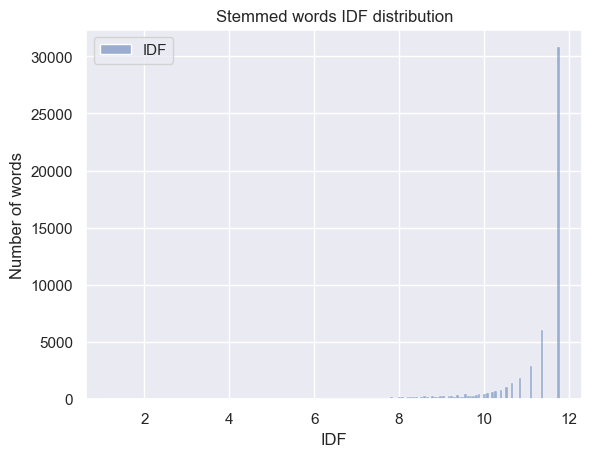

In [16]:
sns.set_theme()
ax = sns.histplot(tokens_idf)
ax.set_xlabel("IDF")
ax.set_ylabel("Number of words")
ax.set_title("Stemmed words IDF distribution")

<Axes: ylabel='Count'>

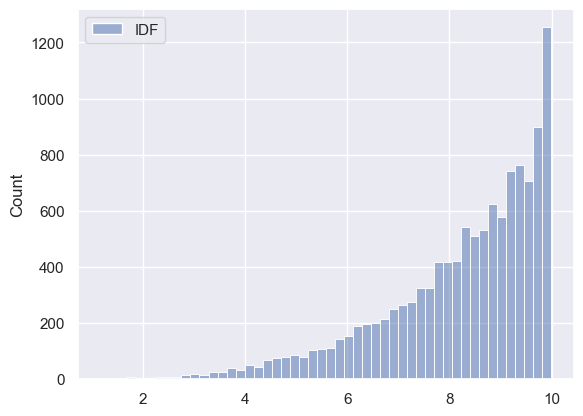

In [15]:
sns.histplot(tokens_idf[tokens_idf["IDF"] < 10])

<Axes: ylabel='Count'>

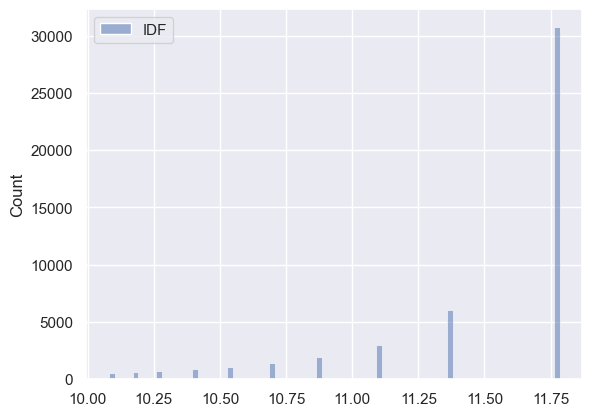

In [17]:
sns.histplot(tokens_idf[tokens_idf["IDF"] > 10])

In [18]:
count_lst = tfidf_matrix.sum(axis=0)


In [21]:
count_lst

matrix([[4.20155197, 2.29862726, 0.88455603, ..., 0.1763484 , 0.17136421,
         0.32997071]])